### Imports

In [7]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# utils
from utils import *

import numpy as np
import pandas as pd
df_train = pd.read_csv("train.csv", index_col=False)
df_valid = pd.read_csv("valid.csv", index_col = False)
df_test = pd.read_csv("test.csv", index_col = False)
df_valid = df_valid.loc[:, df_train.columns]
df_test = df_test.loc[:, df_train.columns]


In [8]:
y_train = df_train['FraudFound_P']
x_train = df_train.drop('FraudFound_P',axis = 1)
y_valid = df_valid['FraudFound_P']
x_valid = df_valid.drop('FraudFound_P',axis = 1)
y_test = df_test['FraudFound_P']
x_test = df_test.drop('FraudFound_P',axis = 1)

from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)

x_train, y_train = smote_enn.fit_resample(x_train, y_train)

In [9]:
clf1 = KNeighborsClassifier(leaf_size=49, n_neighbors=25, p=1)
clf2 = DecisionTreeClassifier(max_depth=6, min_samples_split=2, min_samples_leaf=13,class_weight={0:0.0053, 1: 0.9947})
clf3 = GaussianNB()
clf4 = LogisticRegression(max_iter=1000)
clf5 = LGBMClassifier(lambda_l1 = 2.86e-05,lambda_l2 = 0.754, num_leaves=72, feature_selection = 0.842, bagging_fraction = 0.714, bagging_freq = 2)
clf6 = XGBClassifier( gamma = 0.953, min_child_weight =5, max_depth = 7, eta = 0.2, grow_policy = 'depthwise',n_estimators = 842)
eclf1 = VotingClassifier(estimators=[
        ('knn', clf1), ('dt', clf2), ('gnb', clf3), ('lr', clf4), ('xgb', clf6)], voting='hard')
eclf1 = eclf1.fit(x_train, y_train)

### Validation Performance

In [14]:
from sklearn import metrics
y_pred = eclf1.predict(x_valid)
get_scores(y_valid, y_pred)

Precision: 0.156
Accuracy: 0.745
Recall: 0.746
F1: 0.257
Fbeta: 0.424
ROC AUC: 0.746
PR AUC: 0.131


<AxesSubplot: title={'center': 'Performance on validation set'}, xlabel='Predictions', ylabel='True Labels'>

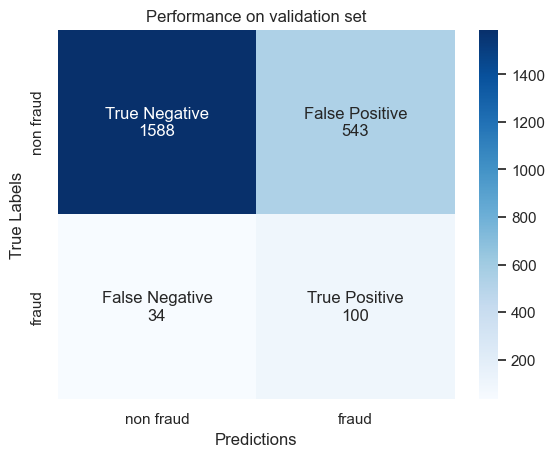

In [11]:
get_confusion_matrix(y_valid, y_pred, "Performance on validation set")

### SHAP

In [11]:
import shap
# Fits the explainer
explainer = shap.Explainer(eclf1.predict, x_train, seed=0)
shap_values = explainer(x_train[1:100,:])

Permutation explainer: 100it [11:36,  7.10s/it]                       


In [12]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()

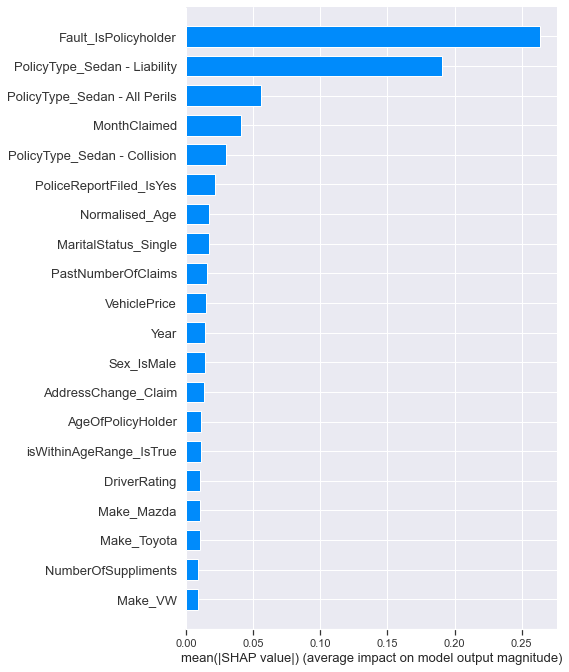

In [13]:
shap.summary_plot(shap_values, x_train, plot_type="bar", feature_names=features)

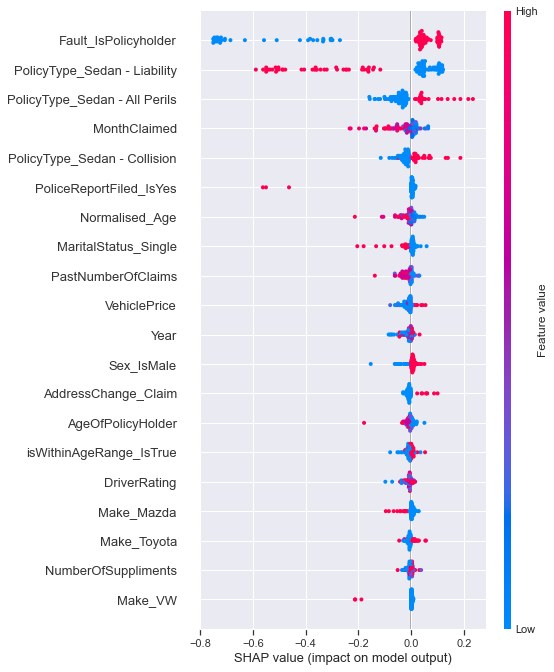

In [15]:
shap.summary_plot(shap_values, x_train[1:100,:],features)

### Test Performance

In [15]:
y_pred = eclf1.predict(x_test)
print(metrics.classification_report(y_test, y_pred, digits = 4))
metrics.fbeta_score(y_test,y_pred,beta = 2)

              precision    recall  f1-score   support

           0     0.9729    0.7743    0.8623      2131
           1     0.1547    0.6567    0.2504       134

    accuracy                         0.7673      2265
   macro avg     0.5638    0.7155    0.5563      2265
weighted avg     0.9245    0.7673    0.8261      2265



0.39819004524886875

<AxesSubplot: title={'center': 'Performance on test set'}, xlabel='Predictions', ylabel='True Labels'>

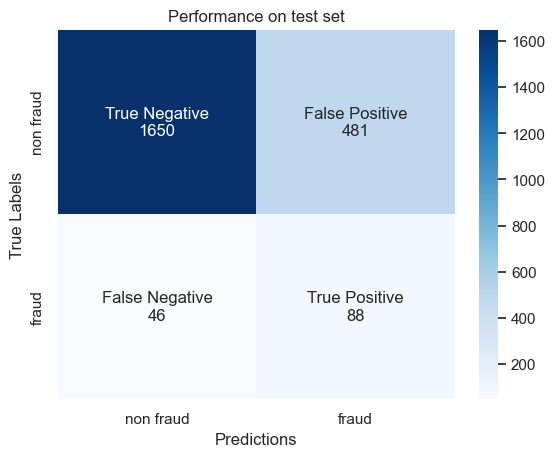

In [17]:
get_confusion_matrix(y_test, y_pred, "Performance on test set")